In [43]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Synthetic dataset creation

In [44]:
n_rows = 10000
start_time = datetime(2025, 4, 1, 0, 0)
time_interval = timedelta(minutes=1)

In [45]:
phases = ['Idle', 'StartUp', 'Running', 'Shutdown']

In [46]:
data = []
for i in range(n_rows):
    timestamp = start_time + i * time_interval
    machine_id = f"M{random.randint(1, 5)}"
    sensor_id = f"S{random.randint(1, 10)}"
    # Create normal values
    op_phase = random.choice(phases)
    base_vibration = np.random.normal(3, 1)
    base_freq = np.random.normal(50, 10)
    accel = np.random.normal(9.8, 1)
    temp = np.random.normal(40, 5)
    load = np.random.randint(20, 90)
    torque = load * 1.2 + np.random.normal(0, 2)
    pressure = np.random.normal(200, 15)    
    humidity = np.random.normal(30, 5)
    speed = np.random.normal(1500, 100)
    # Inject spike anomaly randomly
    if random.random() < 0.01:
        base_vibration += np.random.normal(20, 5)
    # Inject gradual drift
    if i > n_rows * 0.7 and random.random() < 0.005:
        base_vibration += 0.05 * (i - n_rows * 0.7)
    # Inject contextual anomalies
    if op_phase == 'Idle' and base_vibration > 5:
        base_vibration += 5

    row = [timestamp, machine_id, sensor_id, base_vibration, base_freq, accel,
           temp, load, op_phase, torque, pressure, humidity, speed]
    data.append(row)


In [47]:
columns = ["Timestamp", "Machine_ID", "Sensor_ID", "Vibration_Level", "Dominant_Frequency",
       "Acceleration", "Temperature", "Machine_Load", "Operational_Phase", "Torque",
       "Pressure", "Ambient_Humidity", "Machine_Speed"]
df = pd.DataFrame(data, columns=columns)
df.to_csv("iiot_vibration_data.csv", index=False)
df.head()

,Timestamp,Machine_ID,Sensor_ID,Vibration_Level,Dominant_Frequency,Acceleration,Temperature,Machine_Load,Operational_Phase,Torque,Pressure,Ambient_Humidity,Machine_Speed
0,2025-04-01 00:00:00,M4,S1,4.427881,39.240435,9.352529,30.293950,53,Idle,60.960364,221.642818,26.584234,1479.232333
1,2025-04-01 00:01:00,M4,S9,3.819335,37.760480,9.007783,40.199358,41,Shutdown,51.845915,223.463357,32.497185,1466.988185
2,2025-04-01 00:02:00,M4,S1,1.673793,39.400502,9.091677,39.857978,57,StartUp,68.562284,197.556642,25.637807,1339.608665
3,2025-04-01 00:03:00,M4,S8,3.627813,50.693472,9.944991,36.736377,47,StartUp,59.044567,219.650703,31.243976,1637.693849
4,2025-04-01 00:04:00,M3,S6,3.992741,57.391955,10.330791,31.813610,48,Idle,58.954768,209.933724,28.167933,1512.177536


In [48]:
df.shape

(10000, 13)

### SPIKE ANOMALY DETECTION ###

In [49]:

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore
 
# Load dataset
df = pd.read_csv("iiot_vibration_data.csv")
 
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
 
# Label encode Operational_Phase
le = LabelEncoder()
df['Operational_Phase_Encoded'] = le.fit_transform(df['Operational_Phase'])
 
# Feature Engineering: Rolling Statistics
window = 100
df['Rolling_Mean_Vib'] = df['Vibration_Level'].rolling(window).mean()
df['Rolling_Std_Vib'] = df['Vibration_Level'].rolling(window).std()
df.dropna(inplace=True)  # Drop NaN rows from rolling calculations
 
# Create Interaction Features
df['Torque_Load_Ratio'] = df['Torque'] / (df['Machine_Load'] + 1e-3)
df['Speed_Vib_Ratio'] = df['Machine_Speed'] / (df['Vibration_Level'] + 1e-3)
 
# Normalize Features
features_spike = [
    "Vibration_Level", "Dominant_Frequency", "Acceleration",
    "Machine_Load", "Torque", "Operational_Phase_Encoded",
    "Rolling_Mean_Vib", "Rolling_Std_Vib", "Torque_Load_Ratio", "Speed_Vib_Ratio"
]
 
scaler = StandardScaler()
X_spike = scaler.fit_transform(df[features_spike])
 
# Optimize Isolation Forest Hyperparameters
model_spike = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
df['Anomaly_Spike'] = model_spike.fit_predict(X_spike)
df['Anomaly_Spike'] = df['Anomaly_Spike'].map({1: 0, -1: 1})
 
# Hybrid Approach: Z-Score Thresholding
df['Zscore_Vibration'] = df.groupby('Operational_Phase')['Vibration_Level'].transform(zscore)
df['Zscore_Anomaly'] = (df['Zscore_Vibration'].abs() > 2.5).astype(int)
 
# Merge Isolation Forest + Z-score Detection
df['Anomaly_Spike'] = ((df['Anomaly_Spike'] == 1) | (df['Zscore_Anomaly'] == 1)).astype(int)
 
# Cleanup & Save
df.drop(['Rolling_Mean_Vib', 'Rolling_Std_Vib', 'Zscore_Vibration', 'Zscore_Anomaly'], axis=1, inplace=True)
Spike_AD = df.copy()
Spike_AD.to_csv("iiot_spike_anomaly_flagged_improved.csv", index=False)
 
print("Improved Anomaly Detection with Hybrid Model Completed!")


Improved Anomaly Detection with Hybrid Model Completed!


##  Contextual anomaly ###

In [50]:

 
df_context = Spike_AD.copy()
 
# Define simple contextual thresholds (can be improved with SME knowledge)
context_rules = {
    'Idle': {'vibration_max': 5, 'freq_max': 60},
    'StartUp': {'vibration_max': 8, 'freq_max': 80},
    'Running': {'vibration_max': 15, 'freq_max': 100},
    'Shutdown': {'vibration_max': 7, 'freq_max': 70},
}
 
# Apply contextual rules
def check_contextual_anomaly(row):
    phase = row['Operational_Phase']
    vib = row['Vibration_Level']
    freq = row['Dominant_Frequency']
    if phase in context_rules:
        if vib > context_rules[phase]['vibration_max'] or freq > context_rules[phase]['freq_max']:
            return 1
    return 0
 
df_context['Anomaly_Contextual'] = df_context.apply(check_contextual_anomaly, axis=1)
 
from scipy.stats import zscore
# if z- score exceeds +-3 it indicates the extreame deviations
# Phase-specific Z-score for vibration
df_context['Zscore_Vibration'] = df_context.groupby('Operational_Phase')['Vibration_Level'].transform(zscore)
df_context['Zscore_Frequency'] = df_context.groupby('Operational_Phase')['Dominant_Frequency'].transform(zscore)
 
# Flag values beyond 3 standard deviations
df_context['Zscore_Anomaly'] = ((df_context['Zscore_Vibration'].abs() > 3) |
                                 (df_context['Zscore_Frequency'].abs() > 3)).astype(int)
 
# Merge contextual + zscore logic
df_context['Anomaly_Contextual'] = ((df_context['Anomaly_Contextual'] == 1) |
                                     (df_context['Zscore_Anomaly'] == 1)).astype(int)
 
# Drop helper columns if needed
df_context.drop(['Zscore_Vibration', 'Zscore_Frequency', 'Zscore_Anomaly'], axis=1, inplace=True)
 
df_context.to_csv("iiot_spike_contextual_flagged.csv", index=False)
print("Improved Contextual Anomaly Detection Completed!")

Improved Contextual Anomaly Detection Completed!


## Operational Metric Mismatch Detection ###

In [51]:
# %%
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
 
# Load dataset
df_mismatch = df_context.copy()
 
# Polynomial Features for Torque Prediction
poly = PolynomialFeatures(degree=2)  # Using degree-2 polynomial regression
X_poly = poly.fit_transform(df_mismatch[['Machine_Load']])
y = df_mismatch['Torque']
 
model_torque = LinearRegression()
model_torque.fit(X_poly, y)
 
# Predict expected torque
df_mismatch['Predicted_Torque'] = model_torque.predict(X_poly)
 
# Calculate deviation with dynamic thresholding
df_mismatch['Torque_Deviation'] = abs(df_mismatch['Torque'] - df_mismatch['Predicted_Torque'])
 
# Dynamic Threshold (Using 95th Percentile Instead of Fixed 3×std)
threshold = np.percentile(df_mismatch['Torque_Deviation'], 95)
df_mismatch['Anomaly_MetricMismatch'] = (df_mismatch['Torque_Deviation'] > threshold).astype(int)
 
# Example: Speed vs Vibration Ratio Improvement
df_mismatch['Speed_Vib_Ratio'] = df_mismatch['Machine_Speed'] / (df_mismatch['Vibration_Level'] + 1e-3)
scaler = StandardScaler()
df_mismatch['Speed_Vib_Ratio'] = scaler.fit_transform(df_mismatch[['Speed_Vib_Ratio']])  # Normalized for better anomaly detection
 
# Isolation Forest for Refinement
features = ["Torque", "Machine_Load", "Speed_Vib_Ratio"]
X_iso = scaler.fit_transform(df_mismatch[features])
 
iso_forest = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
df_mismatch['ISO_Anomaly'] = iso_forest.fit_predict(X_iso)
df_mismatch['ISO_Anomaly'] = df_mismatch['ISO_Anomaly'].map({1: 0, -1: 1})
 
# Merge All Anomaly Detection Methods
df_mismatch['Anomaly_MetricMismatch'] = ((df_mismatch['Anomaly_MetricMismatch'] == 1) |
                                          (df_mismatch['ISO_Anomaly'] == 1)).astype(int)
 
# Clean Up Helper Columns
df_mismatch.drop(['Predicted_Torque', 'Torque_Deviation', 'Speed_Vib_Ratio', 'ISO_Anomaly'], axis=1, inplace=True)
 
# Save Improved Results
df_mismatch.to_csv("iiot_metric_mismatch_flagged_improved.csv", index=False)
 
print("Improved Metric Mismatch Anomaly Detection Completed!")


Improved Metric Mismatch Anomaly Detection Completed!


## Sensor failure and missing timestamp detection ###


In [53]:

import pandas as pd
import numpy as np
 
# Copy from previous chunk
df_missing = df_mismatch.copy()
 
# Simulate sensor failure: inject random NaNs (if testing)
# Uncomment below to simulate (or skip if real missing data exists)
for col in ['Vibration_Level', 'Dominant_Frequency', 'Torque']:
    df_missing.loc[df_missing.sample(frac=0.01).index, col] = np.nan
 
# Flag missing values
df_missing['Anomaly_MissingData'] = df_missing.isnull().any(axis=1).astype(int)
 
df_missing['Timestamp'] = pd.to_datetime(df_missing['Timestamp'])
 
df_missing.sort_values(['Machine_ID', 'Timestamp'], inplace=True)
 
df_missing['Time_Diff'] = df_missing.groupby('Machine_ID')['Timestamp'].diff().dt.total_seconds()
 
df_missing['Time_Gap_Anomaly'] = (df_missing['Time_Diff'] > 60).astype(int)
 
df_missing['Anomaly_MissingData'] = ((df_missing['Anomaly_MissingData'] == 1) |
                                      (df_missing['Time_Gap_Anomaly'] == 1)).astype(int)
df_missing.drop('Time_Diff', axis=1, inplace=True)
df_missing.drop('Time_Gap_Anomaly', axis=1, inplace=True)
 
# If you want to fill missing values for downstream models
df_missing.fillna(method='ffill', inplace=True)
 
df_missing.to_csv("iiot_all_flags_with_missing.csv", index=False)


## Gradual Drift and multi dimensioanl inconsistency detection ###

In [54]:
# %%
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
 
# Load dataset
df_drift = df_missing.copy()
df_drift['Timestamp'] = pd.to_datetime(df_drift['Timestamp'])
 
# Sort by Timestamp
df_drift.sort_values(by='Timestamp', inplace=True)
 
# **Dynamic Rolling Window Size Based on Operational Phase**
window_sizes = {
    'Idle': 150,
    'StartUp': 100,
    'Running': 200,
    'Shutdown': 120
}
df_drift['Rolling_Window'] = df_drift['Operational_Phase'].map(window_sizes)
 
# **Calculate Rolling Statistics & EMA**
df_drift['Rolling_Mean_Vib'] = df_drift.groupby('Operational_Phase')['Vibration_Level'].transform(lambda x: x.rolling(window_sizes[x.name]).mean())
df_drift['Rolling_Std_Vib'] = df_drift.groupby('Operational_Phase')['Vibration_Level'].transform(lambda x: x.rolling(window_sizes[x.name]).std())
df_drift['EMA_Vibration'] = df_drift.groupby('Operational_Phase')['Vibration_Level'].transform(lambda x: x.ewm(span=50).mean())
 
# **Refined Drift Score (Z-score + EMA)**
df_drift['Drift_Score'] = (df_drift['Vibration_Level'] - df_drift['EMA_Vibration']) / (df_drift['Rolling_Std_Vib'] + 1e-6)
 
# **Dynamic Thresholding Instead of Fixed ±2.5**
dynamic_threshold = df_drift.groupby('Operational_Phase')['Drift_Score'].std() * 2.5
df_drift['Anomaly_Drift'] = df_drift.apply(lambda row: int(abs(row['Drift_Score']) > dynamic_threshold.get(row['Operational_Phase'], 2.5)), axis=1)
 
# **Hybrid Model: Isolation Forest for Refinement**
features = ["Vibration_Level", "Dominant_Frequency", "Torque", "Machine_Load"]
X_iso = df_drift[features].dropna()  # Ensure valid training data
iso_forest = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
df_drift['ISO_Drift_Anomaly'] = iso_forest.fit_predict(X_iso)
df_drift['ISO_Drift_Anomaly'] = df_drift['ISO_Drift_Anomaly'].map({1: 0, -1: 1})
 
# **Merge Both Drift Detection Methods**
df_drift['Anomaly_Drift'] = ((df_drift['Anomaly_Drift'] == 1) | (df_drift['ISO_Drift_Anomaly'] == 1)).astype(int)
 
# **Clean Up Helper Columns**
df_drift.drop(['Rolling_Mean_Vib', 'Rolling_Std_Vib', 'Drift_Score', 'EMA_Vibration', 'ISO_Drift_Anomaly'], axis=1, inplace=True)
 
# Save Improved Data
df_drift.to_csv("iiot_all_anomalies_detected_improved.csv", index=False)
 
print("Improved Drift Anomaly Detection Completed!")


C:\Users\apang\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Improved Drift Anomaly Detection Completed!


In [57]:
# %%
df_drift[['Timestamp', 'Machine_ID', 'Anomaly_Spike', 'Anomaly_Contextual',
          'Anomaly_MetricMismatch', 'Anomaly_MissingData', 'Anomaly_Drift']].head(20)
 
# %%


,Timestamp,Machine_ID,Anomaly_Spike,Anomaly_Contextual,Anomaly_MetricMismatch,Anomaly_MissingData,Anomaly_Drift
99,2025-04-01 01:39:00,M4,0,0,1,0,0
100,2025-04-01 01:40:00,M3,0,0,0,0,0
101,2025-04-01 01:41:00,M4,0,0,0,1,0
102,2025-04-01 01:42:00,M4,0,0,0,0,0
103,2025-04-01 01:43:00,M1,0,0,0,0,0
104,2025-04-01 01:44:00,M1,0,0,0,0,0
105,2025-04-01 01:45:00,M2,1,1,0,0,1
106,2025-04-01 01:46:00,M2,0,0,0,0,0
107,2025-04-01 01:47:00,M2,0,0,0,0,0
108,2025-04-01 01:48:00,M5,0,0,0,0,0


In [58]:
df_main = df_drift.copy()

## Accuracy Code ###

In [59]:
# %%
import numpy as np
 
# Create a copy of the final anomaly-detected dataset
df_eval = df_drift.copy()
 
# Simulate "true" anomalies: randomly inject 1% positive cases for testing
np.random.seed(42)
 
for col in ['Anomaly_Spike', 'Anomaly_Contextual', 'Anomaly_MetricMismatch', 'Anomaly_MissingData', 'Anomaly_Drift']:
    truth_col = f"True_{col}"
    df_eval[truth_col] = 0  # initialize all as normal
    anomaly_indices = df_eval.sample(frac=0.01).index  # 1% of rows as true anomalies
    df_eval.loc[anomaly_indices, truth_col] = 1  # inject simulated "true" anomalies
 

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
 
def evaluate_all_models(df):
    print(" Accuracy Evaluation Results (Simulated Ground Truth)")
 
    for col in ['Anomaly_Spike', 'Anomaly_Contextual', 'Anomaly_MetricMismatch', 'Anomaly_MissingData', 'Anomaly_Drift']:
        true_col = f"True_{col}"
        y_true = df[true_col]
        y_pred = df[col]
 
        cm = confusion_matrix(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
 
        print(f"\n {col}")
        print("Confusion Matrix:")
        print(cm)
        print(f"Precision : {precision:.3f}")
        print(f"Recall    : {recall:.3f}")
        print(f"F1 Score  : {f1:.3f}")


In [61]:
evaluate_all_models(df_eval)

 Accuracy Evaluation Results (Simulated Ground Truth)

 Anomaly_Spike
Confusion Matrix:
[[9540  262]
 [  92    7]]
Precision : 0.026
Recall    : 0.071
F1 Score  : 0.038

 Anomaly_Contextual
Confusion Matrix:
[[9187  615]
 [  92    7]]
Precision : 0.011
Recall    : 0.071
F1 Score  : 0.019

 Anomaly_MetricMismatch
Confusion Matrix:
[[9130  672]
 [  89   10]]
Precision : 0.015
Recall    : 0.101
F1 Score  : 0.026

 Anomaly_MissingData
Confusion Matrix:
[[1993 7809]
 [  21   78]]
Precision : 0.010
Recall    : 0.788
F1 Score  : 0.020

 Anomaly_Drift
Confusion Matrix:
[[9578  224]
 [  99    0]]
Precision : 0.000
Recall    : 0.000
F1 Score  : 0.000


## Observe through Graphs

Anomaly Detection Summary:
Anomaly_Spike: 269 anomalies (2.72%)
Anomaly_Contextual: 622 anomalies (6.28%)
Anomaly_MetricMismatch: 682 anomalies (6.89%)
Anomaly_MissingData: 7887 anomalies (79.66%)
Anomaly_Drift: 224 anomalies (2.26%)


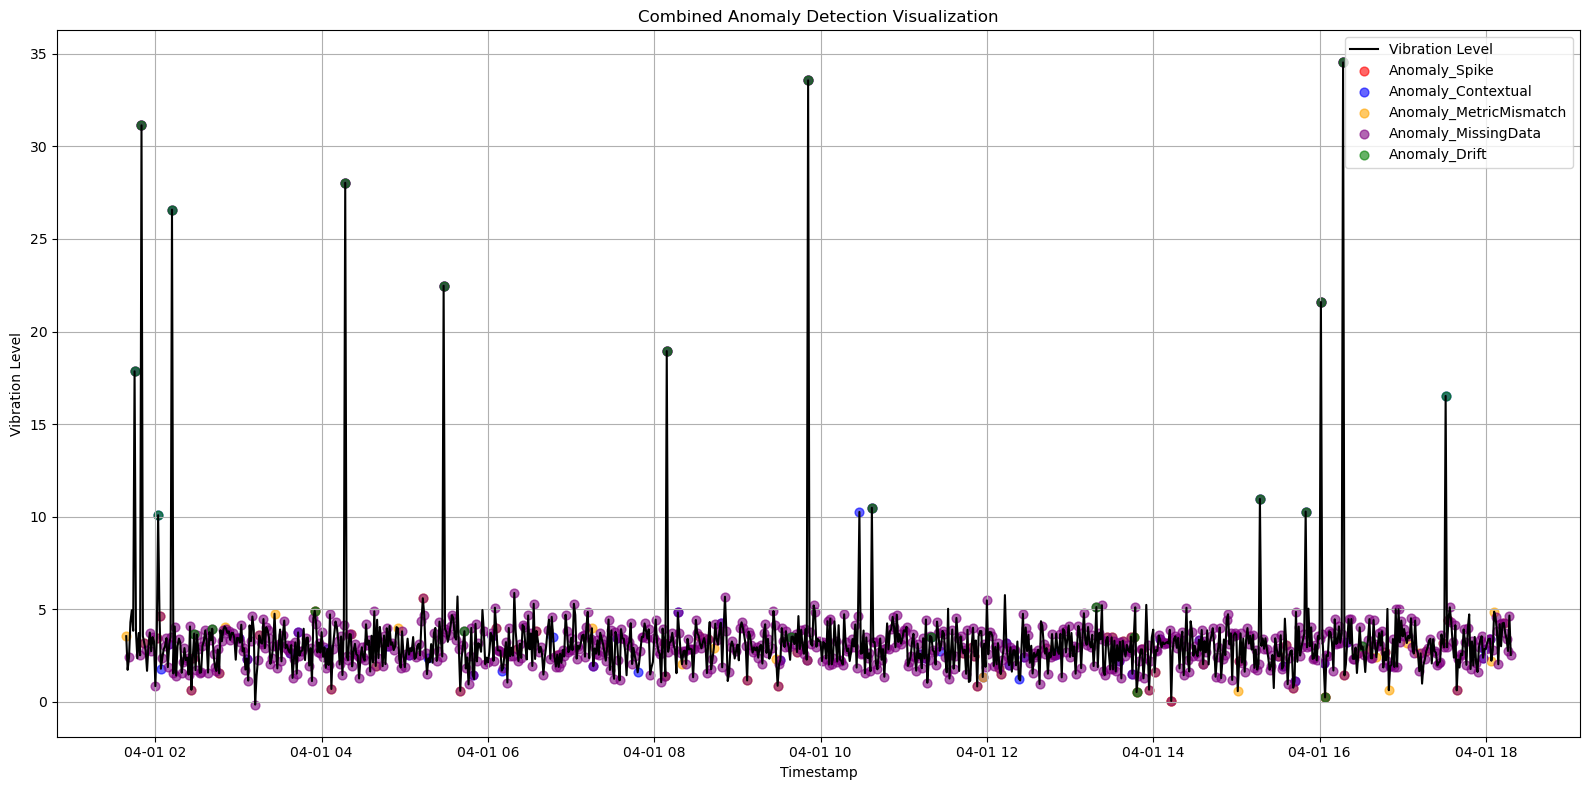

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
 
# Assuming your final dataframe is df_drift
# If you saved it, load it like this:
# df_drift = pd.read_csv("iiot_all_anomalies_detected.csv")
 
print("Anomaly Detection Summary:")
for col in ['Anomaly_Spike', 'Anomaly_Contextual', 'Anomaly_MetricMismatch', 'Anomaly_MissingData', 'Anomaly_Drift']:
    count = df_drift[col].sum()
    percent = 100 * count / len(df_drift)
    print(f"{col}: {count} anomalies ({percent:.2f}%)")
 
df_plot = df_drift.copy().sort_values(by="Timestamp").reset_index(drop=True).iloc[:1000]
 
plt.figure(figsize=(16, 8))
plt.plot(df_plot['Timestamp'], df_plot['Vibration_Level'], label='Vibration Level', color='black')
 
anomaly_colors = {
    'Anomaly_Spike': 'red',
    'Anomaly_Contextual': 'blue',
    'Anomaly_MetricMismatch': 'orange',
    'Anomaly_MissingData': 'purple',
    'Anomaly_Drift': 'green'
}
 
for col, color in anomaly_colors.items():
    anomalies = df_plot[df_plot[col] == 1]
    plt.scatter(anomalies['Timestamp'], anomalies['Vibration_Level'],
                label=col, color=color, s=40, alpha=0.6)
 
plt.title("Combined Anomaly Detection Visualization")
plt.xlabel("Timestamp")
plt.ylabel("Vibration Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 
# %%
